In [131]:
%pylab inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Attanasio, Orazio, Britta Augsburg, Ralph De Haas, Emla Fitzsimons, and Heike Harmgart. 2015. "The Impacts of Microfinance: Evidence from Joint-Liability Lending in Mongolia." American Economic Journal: Applied Economics, 7 (1): 90-122.

Paper and dataset can be found at: https://www.aeaweb.org/articles?id=10.1257/app.20130489

This study surveyed respondents before the random assignment of loans (either none, group liability, or individual liability), which could be useful in constructing a predicted score for outcomes of interest. In the paper, the regression model was roughly
$$ Y_1 = \alpha_0 + \alpha_1 G + \alpha_X X_0 + Y_0 $$
where $Y_t$ represented the outcome of interest before ($t=0$) and after ($t=1$) the loan period, $X_0$ represents individual characteristics measured in the inital survey, and $G$ represents the type of loan offered.

The measured outcomes include:
 - loans taken during period, loans defaulted, and loans whose repayment was delayed
 - household and individual self-employment and income
 - hours worked inside/outside house
 - consumption on various categories and savings
 - schooling


# 1. Load Data

In [132]:
# Loads followup ent data and identifies rescodes
data_type_followup = "f_Sections F,G,h - Ent.dta"
data_file_followup = "Analysis files/data/Followup/{0}".format(data_type_followup)
data_ent_followup = pd.read_stata(data_file_followup, convert_categoricals=False)

# takes the rescode column for the followup and removes duplicates 
rescodes_ent_followup = data_ent_followup[['rescode']]
rescodes_ent_followup = rescodes_ent_followup.drop_duplicates()

In [133]:
# Loads baseline education data and identifies rescodes
data_type_baseline = "education.dta"
data_file_baseline = "Analysis files/data/Baseline/{0}".format(data_type_baseline)
data_edu_baseline = pd.read_stata(data_file_baseline, convert_categoricals=False)

# takes the rescode column for the baseline and removes duplicates 
rescodes_edu_baseline = data_edu_baseline[['rescode']]
rescodes_edu_baseline = rescodes_edu_baseline.drop_duplicates()

In [134]:
# checks for accurate attrition rate
num_rescodes_edu_baseline = len(rescodes_edu_baseline)
num_rescodes_ent_followup = len(rescodes_ent_followup)
print("Number of households at baseline: ", num_rescodes_edu_baseline)
print("Number of households at followup: ", num_rescodes_ent_followup)
print("About the reported 16% attrition rate: ", 100 * (num_rescodes_edu_baseline - num_rescodes_ent_followup) / num_rescodes_edu_baseline)

Number of households at baseline:  1148
Number of households at followup:  961
About the reported 16% attrition rate:  16.28919860627178


In [135]:
# Removes attrition from baseline education data merge and sanity checks
updated_edu_baseline = rescodes_ent_followup.merge(data_edu_baseline, on="rescode", how="left")

updated_baseline_edu_rescodes = updated_edu_baseline["rescode"]
updated_baseline_edu_rescodes = updated_baseline_edu_rescodes.drop_duplicates()

num_updated_baseline_edu_rescodes = len(updated_baseline_edu_rescodes)
print("Number of households at followup: ", num_rescodes_ent_followup)
print("Number of households at adjusted baseline: ", num_updated_baseline_edu_rescodes)

print("Length of data_followup: ", len(data_ent_followup))
print("Length of updated_baseline: ", len(updated_edu_baseline))


Number of households at followup:  961
Number of households at adjusted baseline:  961
Length of data_followup:  961
Length of updated_baseline:  961


In [136]:
# Loads baseline ent data and identifies rescodes
data_type_baseline = "Sections F,G,h - Ent.dta"
data_file_baseline = "Analysis files/data/Baseline/{0}".format(data_type_baseline)
data_ent_baseline = pd.read_stata(data_file_baseline, convert_categoricals=False)

# takes the rescode column for the baseline and removes duplicates 
rescodes_ent_baseline = data_ent_baseline['rescode']
rescodes_ent_baseline = rescodes_ent_baseline.drop_duplicates()

In [137]:
# checks for accurate attrition rate
num_rescodes_ent_baseline = len(rescodes_ent_baseline)
print("Number of households at baseline: ", num_rescodes_ent_baseline)
print("Number of households at followup: ", num_rescodes_ent_followup)
print("About the reported 16% attrition rate: ", 100 * (num_rescodes_ent_baseline - num_rescodes_ent_followup) / num_rescodes_ent_baseline)

Number of households at baseline:  1148
Number of households at followup:  961
About the reported 16% attrition rate:  16.28919860627178


In [138]:
#Removes attrition from baseline education data merge and sanity checks
updated_ent_baseline = rescodes_ent_followup.merge(data_ent_baseline, on="rescode", how="left")
updated_baseline_ent_rescodes = updated_ent_baseline["rescode"]
updated_baseline_ent_rescodes = updated_baseline_ent_rescodes.drop_duplicates()

num_updated_baseline_edu_rescodes = len(updated_baseline_edu_rescodes)
print("Number of households at followup: ", num_rescodes_ent_followup)
print("Number of households at adjusted baseline: ", num_updated_baseline_edu_rescodes)

print("Length of data_followup: ", len(data_ent_followup))
print("Length of updated_baseline: ", len(updated_edu_baseline))

Number of households at followup:  961
Number of households at adjusted baseline:  961
Length of data_followup:  961
Length of updated_baseline:  961


In [139]:
# Now, we have updated_edu_baseline, updated_ent_baseline, and data_ent_followup. 
# Trims down each data frame to the columns we want
# Checks that rescodes are all in the same order

edu_baseline = updated_edu_baseline
ent_baseline = updated_ent_baseline[['rescode', 'treatment', 'enterprise', 'jointent', 'nrjointent', 'soleent', 'partnent']]
ent_followup = data_ent_followup[['rescode', 'treatment', 'f_enterprise', 'f_jointent', 'f_nrjointent', 'f_soleent', 'f_partnent']]

# Rescodes loaded in order from each df into separate arrays
b_edu_rescodes = list()
for i in edu_baseline.index:
    b_edu_rescodes.append(edu_baseline.at[i, "rescode"]) 

b_ent_rescodes = list()
for i in ent_baseline.index:
    b_ent_rescodes.append(ent_baseline.at[i, "rescode"]) 
    
f_ent_rescodes = list()
for i in ent_followup.index:
    f_ent_rescodes.append(ent_followup.at[i, "rescode"])  

# Rescode arrays elements compared in order to find discrepancies
no_mismatch = True
for i in range(len(b_edu_rescodes)):
    if b_edu_rescodes[i] != b_ent_rescodes[i]:
        no_mismatch = False
    if b_edu_rescodes[i] != f_ent_rescodes[i]:
        no_mismatch = False
    if b_ent_rescodes[i] != f_ent_rescodes[i]:
        no_mismatch = False
if no_mismatch:
    print("No rescode order mismatches; safe to join")

No rescode order mismatches; safe to join


In [140]:
# Creates big array with edu_baseline, ent_baseline, and ent_followup. Corrects NaN values to zero.
ent_edu_master = ent_baseline.join(ent_followup[['f_enterprise', 'f_jointent', 'f_nrjointent', 'f_soleent', 'f_partnent']])
#rowsToDrop = ent_edu_master[ent_edu_master.index > len(updated_edu_baseline.index) - 1]
#ent_edu_master = ent_edu_master.drop(rowsToDrop.index, axis=0)
print(len(ent_edu_master))
ent_edu_master = ent_edu_master.join(edu_baseline[["edulow", "eduvoc", "eduhigh"]])
ent_edu_master = ent_edu_master.fillna(0)
print("rescode treatment enterprise jointent nrjointent soleent partnent f_enterprise f_jointent f_nrjointent f_soleent f_partnent edulow eduvoc eduhigh")

961
rescode treatment enterprise jointent nrjointent soleent partnent f_enterprise f_jointent f_nrjointent f_soleent f_partnent edulow eduvoc eduhigh


In [141]:
#Creates new data frame with twice as many rows (first set for baseline, second for followup) 
print(len(ent_edu_master))
ent_edu_graphing = ent_edu_master.append(ent_edu_master, ignore_index=True)
print(len(ent_edu_master))


#new row to indicate baseline (false) or followup (true)
ent_edu_graphing['baselineOrFollowup'] = ent_edu_graphing.index > len(updated_edu_baseline.index) - 1

#adds combined_enterprise that contains enterprise for the first half and f_enterprise for the second half
df = pd.DataFrame({'enterprise': ent_edu_master['enterprise'].append(ent_edu_master['f_enterprise'], ignore_index=True)})
ent_edu_graphing['combined_enterprise'] = df['enterprise']

#adds combined_jointent that contains jointent for the first half and f_jointent for the second half
df = pd.DataFrame({'jointent': ent_edu_master['jointent'].append(ent_edu_master['f_jointent'], ignore_index=True)})
ent_edu_graphing['combined_jointent'] = df['jointent']

#adds combined_enterprise that contains soleent for the first half and f_soleent for the second half
df = pd.DataFrame({'soleent': ent_edu_master['soleent'].append(ent_edu_master['f_soleent'], ignore_index=True)})
ent_edu_graphing['combined_soleent'] = df['soleent']

#adds combined_enterprise that contains partnent for the first half and f_partnent for the second half
df = pd.DataFrame({'partnent': ent_edu_master['partnent'].append(ent_edu_master['f_partnent'], ignore_index=True)})
ent_edu_graphing['combined_partnent'] = df['partnent']
ent_edu_graphing['education'] = ent_edu_graphing['edulow'] + ent_edu_graphing['eduvoc'] * 2 + ent_edu_graphing['eduhigh'] * 3


copyDF = ent_edu_graphing.copy()
copyDF["education"] = 4
ent_edu_graphing = ent_edu_graphing.append(copyDF, ignore_index=True, sort=False)

print('rescode	treatment	enterprise	jointent	nrjointent	soleent	partnent	f_enterprise	f_jointent	f_nrjointent	f_soleent	f_partnent	edulow	eduvoc	eduhigh	baselineOrFollowup	education')
ent_edu_graphing

961
961
rescode	treatment	enterprise	jointent	nrjointent	soleent	partnent	f_enterprise	f_jointent	f_nrjointent	f_soleent	f_partnent	edulow	eduvoc	eduhigh	baselineOrFollowup	education


,rescode,treatment,enterprise,jointent,nrjointent,soleent,partnent,f_enterprise,f_jointent,f_nrjointent,...,f_partnent,edulow,eduvoc,eduhigh,baselineOrFollowup,combined_enterprise,combined_jointent,combined_soleent,combined_partnent,education
0,11101,0.0,1,0.0,0.0,1.0,0.0,1,0.0,0.0,...,1.0,0.0,0.0,1.0,False,1,0.0,1.0,0.0,3.0
1,11102,0.0,1,2.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,False,1,2.0,1.0,0.0,3.0
2,11103,0.0,1,2.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,False,1,2.0,1.0,0.0,3.0
3,11201,0.0,0,0.0,0.0,0.0,0.0,1,1.0,1.0,...,0.0,0.0,0.0,1.0,False,0,0.0,0.0,0.0,3.0
4,11203,0.0,1,0.0,0.0,1.0,0.0,1,1.0,1.0,...,0.0,1.0,0.0,0.0,False,1,0.0,1.0,0.0,1.0
5,11301,0.0,1,1.0,2.0,0.0,0.0,1,1.0,2.0,...,0.0,0.0,1.0,0.0,False,1,1.0,0.0,0.0,2.0
6,11302,0.0,1,1.0,2.0,0.0,0.0,1,1.0,1.0,...,0.0,0.0,1.0,0.0,False,1,1.0,0.0,0.0,2.0
7,11304,0.0,1,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,False,1,0.0,1.0,0.0,1.0
8,11402,0.0,1,0.0,0.0,1.0,0.0,1,1.0,1.0,...,0.0,0.0,0.0,1.0,False,1,0.0,1.0,0.0,3.0
9,11403,0.0,1,1.0,1.0,0.0,0.0,1,1.0,1.0,...,1.0,0.0,0.0,1.0,False,1,1.0,0.0,0.0,3.0


In [142]:
df_control_graphing = ent_edu_graphing.loc[ent_edu_graphing['treatment'] == 0, :]
df_individual_graphing = ent_edu_graphing.loc[ent_edu_graphing['treatment'] == 1, :]
df_group_graphing = ent_edu_graphing.loc[ent_edu_graphing['treatment'] == 2, :]

In [143]:
numEdulow= updated_edu_baseline['edulow'].sum()
numEduvoc= updated_edu_baseline["eduvoc"].sum()
numEduHigh= updated_edu_baseline["eduhigh"].sum()
totalNumHH = len(updated_edu_baseline.index)
print(numEdulow/totalNumHH)
print(numEduvoc/totalNumHH)
print(numEduHigh/totalNumHH)

0.13007284079084286
0.2008324661810614
0.6690946930280958


In [144]:
def percentages(dataframe, variable):
    #Finding increase in enterprise with control
    numBaseline = dataframe[dataframe.index < 961][variable].sum()
    numFollowUp = dataframe[dataframe.index < 1922][variable].sum() - numBaseline
    totalNumHH = len(updated_edu_baseline.index)

    percentageBaselineEnterpriseC = numBaseline/totalNumHH * 100
    percentageFollowUpEnterpriseC = numFollowUp/totalNumHH * 100
    print("Percentage of " + variable + " @ baseline: ", percentageBaselineEnterpriseC)
    print("Percentage of " + variable + " @ followup: ", percentageFollowUpEnterpriseC)

In [145]:
percentages(df_group_graphing, "combined_enterprise")

Percentage of combined_enterprise @ baseline:  22.06035379812695
Percentage of combined_enterprise @ followup:  24.453694068678463


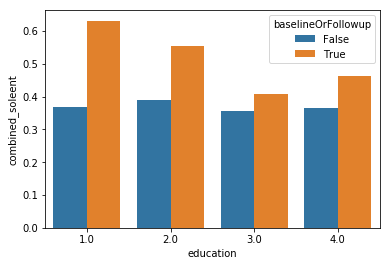

In [151]:
groupLoanGraph = sns.barplot(x='education', y="combined_soleent", hue="baselineOrFollowup", data=df_group_graphing, ci=None)

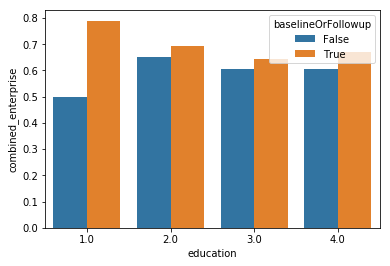

In [154]:
individualLoanGraph = sns.barplot(x='education', y="combined_enterprise", hue="baselineOrFollowup", data=df_group_graphing, ci=None)